 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D-09   r2 =  0.3053054387937D-36
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D-09   r2 =  0.3053054387937D-36
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D-09   r2 =  0.3053054387937D-32
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1000000000000D-09   r2 =  0.3053054387937D-32
 lsoda--  warning..internal t (=r1) 

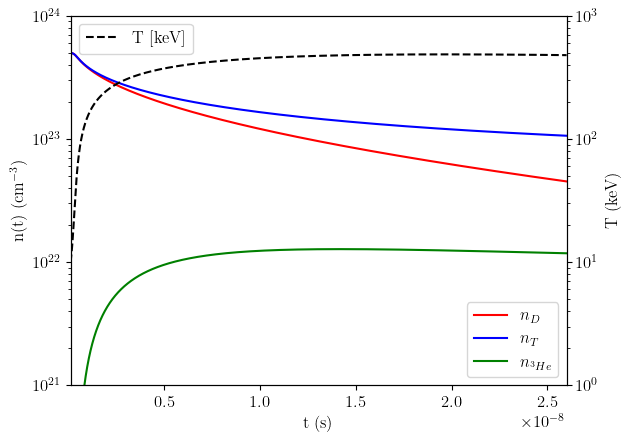

1.348912239074707 sec


In [19]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 12})
rc('text', usetex=True)
import time

####reactivity parametrization of DT, D3He, DDp, DDn reactions
def react(T,  channel):
    if channel == 'dt':
        Bg  = 34.3827;     mc2 = 1124656;     C1  = 1.17302e-9;  C2  = 1.51361e-2;
        C3  = 7.51886e-2;  C4  = 4.60643e-3;  C5  = 1.35e-2;     C6  = -1.0675e-4;
        C7  = 1.366e-5
    if channel == 'd3he':
        Bg  = 68.7508;     mc2 = 1124572;     C1  = 5.51036e-10; C2  = 6.41918e-3
        C3  = -2.02896e-3; C4  = -1.91080e-5; C5  = 1.35776e-4;  C6  = C7 = 0
    if channel == 'ddp':
        Bg  = 31.397;      mc2 = 937814;      C1  = 5.65718e-12; C2  = 3.41267e-3;
        C3  = 1.99167e-3;  C4  = C6 = C7 = 0; C5  = 1.0506e-5;
    if channel == 'ddn':
        Bg  = 31.397;      mc2 = 937814;      C1  = 5.4336e-12;  C2  = 5.85778e-3;
        C3  = 7.68222e-3;  C4  = C6 = C7 = 0; C5  = -2.964e-6;
        
    teta = T / ( 1 - T*(C2+T*(C4+T*C6))/(1 +T*(C3+T*(C5+T*C7))) )
    ksi = (Bg*Bg/teta/4)**(1/3)
    reactivity = C1*teta*np.sqrt(ksi/(mc2*T**3))*np.exp(-3*(ksi)) 
    return reactivity
###################################################################

start = time.time()

def F(s,t_int):
    
    # Fusion reaction rates
    r_dd_p = react(s[0],'ddp') 
    r_dd_n = react(s[0],'ddn') 
    r_dt =   react(s[0],'dt')
    r_d3he = react(s[0],'d3he')    
    r_dd =   react(s[0],'ddp') + react(s[0],'ddn')
    
    # Q values and energies for fusion reactions in MeV
    Q_ddp = 4.03; Q_ddn = 3.27; Q_d3he = 18.35
    E_ddn = 0.82; E_adt = 3.52; E_n1 = 2.45;   E_n2 = 14.07
    
    ne = 1e+24 # Electron density in cm^-3, assuming const
    
    # D, T and 3He densities in cm^-3
    nd   = -0.5*r_dd   * s[1]*s[1] - r_dt  *s[1]*s[2] -r_d3he*s[1]*s[3]
    nt   = +0.5*r_dd_p * s[1]*s[1] - r_dt  *s[1]*s[2]
    n3he = +0.5*r_dd_n * s[1]*s[1] - r_d3he*s[1]*s[3]
    
    # Energy yield in MeV/cm^3 for charged particles
    Ech =  (0.5*r_dd_p * s[1]*s[1]* Q_ddp + r_dt  * s[1]*s[2]* E_adt+
            0.5*r_dd_n * s[1]*s[1]* E_ddn + r_d3he* s[1]*s[3]* Q_d3he)
    
    # Energy yield in MeV/cm^3 for Neutrons
    En =    0.5*r_dd_n * s[1]*s[1]* E_n1 +  r_dt  * s[1]*s[2]* E_n2
    
    ###Bremsstrahlung power radiation losses in Mev/cm^3
    Pbr = 0.334e-17*np.sqrt(s[0])*(s[1]+s[2]+4*s[3])*ne
    
    ### Temperature in keV
    T =  (2/3)*1e+3*(Ech-Pbr)/(s[1]+s[2]+2*s[3]+ne)
    
    return [T, nd, nt, n3he, Ech, En, Pbr]

t_min = 1e-10   # start-time in seconds
t_max = 2.6e-8 # finish-time in seconds
t_int = np.linspace(t_min,t_max, 10000) # number of time intervals
#initial concentrations n0 (0,1,2) in keV/cm^3 and Temp(3) and energy Ech(4), En(5), Pbr(6)
n0=[10, 5e+23,5e+23,0, 0, 0, 0] 
s = odeint(F,n0,t_int)

fig, ax1 = plt.subplots()
ax1.plot(t_int,s[:,1],'r-', linewidth=1.5)
ax1.plot(t_int,s[:,2],'b-', linewidth=1.5)
ax1.plot(t_int,s[:,3],'g-', linewidth=1.5)
ax1.set(ylim=[1e+21, 1e+24], yscale = 'log')
ax1.set(xlim=[t_min,t_max])
#ax1.set(xlim=[t_min,t_max])
ax1.set_ylabel('n(t) (cm$^{-3}$)')
plt.xlabel('t (s)')
plt.legend(['$n_{D}$', '$n_{T}$', '$n_{^{3}He}$'], loc='lower right')
ax2 = ax1.twinx()


ax2.plot(t_int,s[:,0],'k--', linewidth=1.5)
ax2.set(ylabel = 'T (keV)', yscale ='log', ylim = [1, 1000])
ax2.legend(['T [keV]'], loc='upper left')
#plt.savefig('DTfuel_burn.jpg', dpi= 1000,bbox_inches='tight')
plt.show()
end = time.time() - start
print(end,'sec')